In [1]:
from qiskit import *

import torch
import torch.nn as nn

# Import from Qiskit Aer noise module
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

import numpy as np
import matplotlib

%matplotlib inline
%matplotlib inline

In [2]:
def construct_noise(nqubits):
      
    noise = NoiseModel()

    ### ----------------- Bit-flip error ----------------- 
    # Error probabilities
    p_gate1_1qubit = 0.00031344
    p_gate1_2qubit = 0.0085165

    # QuantumError objects
    error_gate1 = pauli_error([('X',p_gate1_1qubit), ('I', 1 - p_gate1_1qubit)])
    error_gate2 = pauli_error([('X',p_gate1_2qubit), ('I', 1 - p_gate1_2qubit)])
    error_gate2 = error_gate2.tensor(error_gate2)

    ### ----------------- Thermal relaxation ----------------- 
    # T1 and T2 values for alll= qubits
    T1s = np.random.normal(153.404e3, 0, nqubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(62.028e3, 0, nqubits)  # Sampled from normal distribution mean 50 microsec

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2*T1s[j]) for j in range(nqubits)])

    # Instruction times (in nanoseconds)
    time_sx = 35.55555555555556
    time_rz = 35.55555555555556
    time_cx = 368
    time_measure = 5351.111

    # QuantumError objects
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)]
    errors_sx = [thermal_relaxation_error(t1, t2, time_sx) for t1, t2 in zip(T1s, T2s)]
    errors_rz = [thermal_relaxation_error(t1, t2, time_rz) for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(thermal_relaxation_error(t1b, t2b, time_cx)) for t1a, t2a in zip(T1s, T2s)] for t1b, t2b in zip(T1s, T2s)]


    ### ----------------- Compose both noise models ----------------- 
    # Add errors to noise model
    for j in range(nqubits):
        noise.add_quantum_error(errors_measure[j], "measure", [j])
        noise.add_quantum_error(error_gate1.compose(errors_sx[j]), "sx", [j])
        noise.add_quantum_error(error_gate1.compose(errors_rz[j]), "rz", [j])
        for k in range(nqubits):
            noise.add_quantum_error(error_gate2.compose(errors_cx[j][k]), "cx", [j, k])

    return noise


def describe_qubit(gate, properties):
    us = 1e6
    ns = 1e9
    T1_avg = 0
    T2_avg = 0
    error_avg = 0
    length_avg = 0

    print("\nFor the", gate, "gate:\n")

    if gate == 'cx':
        n = 0
        for gate_i in props.gates:
            if 'cx' in gate_i.name:
                n += 1
                print(" - {0} gate on qubits {1} error rate is {2}\n"
                      " - Gate duration of {3} nanoseconds\n".format(gate_i.name, gate_i.qubits, gate_i.parameters[0].value, gate_i.parameters[1].value))
                error_avg += gate_i.parameters[0].value
                length_avg += gate_i.parameters[1].value
        print("The avg. gate error = {0}\n"
              "The avg. gate duration = {1} nanoseconds\n".format(error_avg/n, length_avg/n))

    else:
        n = config.n_qubits
        for i in range(n):
            print("Qubit {0} has a \n"
                  "  - T1 time of {1} microseconds\n"
                  "  - T2 time of {2} microseconds\n"
                  "  - Gate error of {3}\n"
                  "  - Gate duration of {4} nanoseconds\n"
                 .format(
                      i,
                      properties.t1(i) * us,
                      properties.t2(i) * us,
                      properties.gate_error(gate, i),
                      properties.gate_length(gate, i) * ns))
            T1_avg += properties.t1(i) * us
            T2_avg += properties.t2(i) * us
            error_avg += properties.gate_error(gate, i)
            length_avg += properties.gate_length(gate, i) * ns
        print("The avg. T1 time = {0} microseconds\n"
              "The avg. T2 time = {1} microseconds\n"
              "The avg. gate error = {2}\n"
              "The avg. gate duration = {3} nanoseconds\n".format(T1_avg/n, T2_avg/n, error_avg/n, length_avg/n))

In [3]:
real_qc = False
Noise = False
nqubits = 4

if real_qc:
    # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
    provider = IBMQ.load_account()
    # Get backend for experiment
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = provider.get_backend('ibmq_lima')
    
    config = backend.configuration()
    print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
          "{4} OpenPulse programs. The basis gates supported on this device are {5}."
          "".format(config.backend_name,
                    config.backend_version,
                    config.n_qubits,
                    '' if config.n_qubits == 1 else 's',
                    'supports' if config.open_pulse else 'does not support',
                    config.basis_gates))
    props = backend.properties()           
    describe_qubit('cx', props)
    
else:
    if Noise:
        noise = construct_noise(nqubits)
    else:
        noise = None
    backend = AerSimulator(noise_model=noise)

The minimum value of the Hamiltonian: -21 the configuration: 0101


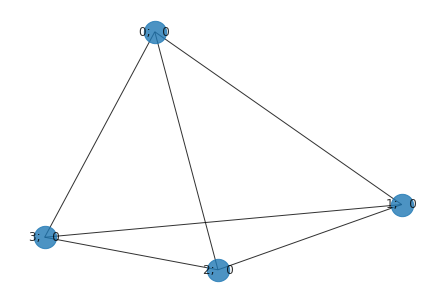

In [4]:
import networkx as nx
from itertools import combinations


Ising_coeff = [
            [0, 2, 3, 4],
            [0, 0, 8, 1],
            [0, 0, 0, 11],
            [0, 0, 0, 0]
        ]

"""
Ising_coeff = [
            [1, 4],
            [0, 1]
        ]
"""

# Visualize the connectivity of the Ising model
G = nx.Graph()
pairs = []
for i in range(0, nqubits):
    G.add_node(i, weight = Ising_coeff[i][i])
    for j in range(i+1, nqubits):
        pairs.append((i, j, Ising_coeff[i][j]))
G.add_weighted_edges_from(pairs)
labels = {n: str(n) + ';   ' + str(G.nodes[n]['weight']) for n in G.nodes}
nx.draw(G, with_labels=True, labels=labels, alpha=0.8, node_size=500)


# @jit(nopython=True, parallel=True, fastmath=True)
def H_Ising(bitstring, Ising_coeff):
    spins = []
    for bit in bitstring:
        if bit == '0':
            spins.append(-1)
        elif bit == '1':
            spins.append(1)
    H = 0
    for i in range(0, nqubits):
        H += Ising_coeff[i][i]*spins[i]
        for j in range(i+1, nqubits):
            H += Ising_coeff[i][j]*spins[i]*spins[j]
    return H


H_min = 10000
for i in range(2**len(Ising_coeff)):
    bitstring = np.binary_repr(i, nqubits)
    if H_Ising(bitstring, Ising_coeff) < H_min:
        H_min = H_Ising(bitstring, Ising_coeff)
        config_min = bitstring
print('The minimum value of the Hamiltonian:', H_min, 'the configuration:', config_min)

In [5]:


def compute_expectation(counts, Ising_coeff):   
    """
    Computes expectation value based on measurement results
    """   
    sum = 0
    sum_count = 0
    for bitstring, count in counts.items():
        sum += count*H_Ising(bitstring, Ising_coeff)
        sum_count += count
    return sum/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(Ising_coeff, theta): 
    """
    Creates a parametrized qaoa circuit
    """   
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i in range(nqubits):
            for j in range(i+1, nqubits):
                if Ising_coeff != 0:
                    qc.rzz(2 * Ising_coeff[i][j]*gamma[irep], i, j)
        # mixer unitary
        for i in range(nqubits):
            qc.rz(2 * Ising_coeff[i][i]*gamma[irep], i)
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(theta):
    """
    Runs parametrized circuit and get expectation value
    
    """
    qc = create_qaoa_circ(Ising_coeff, theta)       
    qc = transpile(qc, backend=backend)
    if seed:
        seed_simulator = 10
    else:
        seed_simulator = None
    counts = backend.run(qc, seed_simulator=seed_simulator, nshots=shots).result().get_counts()       

    return compute_expectation(counts, Ising_coeff)

In [6]:
circuit = create_qaoa_circ(Ising_coeff, [1, 1])
circuit = transpile(circuit, backend=backend)
circuit.draw()

global phase: 0
        ┌───┐                                 ┌────────────────┐»
   q_0: ┤ H ├─■───────■────────────────■──────┤ U3(2,-π/2,π/2) ├»
        ├───┤ │ZZ(4)  │                │      └────────────────┘»
   q_1: ┤ H ├─■───────┼───────■────────┼────────────■───────────»
        ├───┤         │ZZ(6)  │ZZ(16)  │            │           »
   q_2: ┤ H ├─────────■───────■────────┼────────────┼───────────»
        ├───┤                          │ZZ(8)       │ZZ(2)      »
   q_3: ┤ H ├──────────────────────────■────────────■───────────»
        └───┘                                                   »
meas: 4/════════════════════════════════════════════════════════»
                                                                »
«                                             ░ ┌─┐         
«   q_0: ─────────────────────────────────────░─┤M├─────────
«        ┌────────────────┐                   ░ └╥┘┌─┐      
«   q_1: ┤ U3(2,-π/2,π/2) ├───────────────────░──╫─┤M├──────
«        └────────────────┘┌────────────────┐ ░  ║ └╥┘┌─┐   
«   q_2: ─────■────────────┤ U3(2,-π/2,π/2) ├─░──╫──╫─┤M├───
«             │ZZ(22)      ├────────────────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ─────■────────────┤ U3(2,-π/2,π/2) ├─░──╫──╫──╫─┤M├
«                          └────────────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/════════════════════════════════════════╩══╩══╩══╩═
«                                                0  1  2  3

In [7]:
def optimizer(
    eps: float, 
    theta: list[float], 
    lr: float, 
    momentum: float
):
    grad = [0 for t in range(len(theta))]
    for i in range(len(theta)):
        # Uses a symmetric difference to calulate the gradient
        theta[i] += eps
        grad[i] = get_expectation(theta)
        theta[i] -= 2*eps
        grad[i] -= get_expectation(theta)
        grad[i] /= 2*eps
        theta[i] += eps      
        # Update the parameters by gradient descent with momentum
        v[i] = momentum*v[i] - lr*grad[i]
        theta[i] = theta[i] + v[i]

    return theta

In [8]:
seed = True
shots = 1024
eps = 10**-3
p = 4
lr = 0.0001
momentum = 0.5
num_steps = 50
schedule = [30]
lr_decay = 0.1


# Initialize the parameters
torch.manual_seed(0)
theta = torch.empty(int(2*p))
torch.nn.init.normal_(theta, mean=0.5, std=0.01)
theta = theta.tolist()


expectation_list = []
theta_list = []
# Perform SGD with momentum
v = [0 for i in range(int(2*p))]
for i in range(num_steps + 1):      # Update the parameters
    expectation = get_expectation(theta)
    expectation_list.append(expectation)
    if i in schedule:      # Learning rate scheduling (step)
        lr = lr*lr_decay
    theta = optimizer(eps, theta, lr, momentum)
    if (i != 0) and (i % 10 == 0):
        theta_list.append(theta)
    print('The expectation values at iteration =', i, 'is:', expectation)

The expectation values at iteration = 0 is: 12.9375
The expectation values at iteration = 1 is: -11.3359375
The expectation values at iteration = 2 is: -10.1640625
The expectation values at iteration = 3 is: -14.384765625
The expectation values at iteration = 4 is: -15.513671875
The expectation values at iteration = 5 is: -15.763671875
The expectation values at iteration = 6 is: -16.083984375
The expectation values at iteration = 7 is: -15.732421875
The expectation values at iteration = 8 is: -15.978515625
The expectation values at iteration = 9 is: -17.107421875
The expectation values at iteration = 10 is: -16.68359375
The expectation values at iteration = 11 is: -16.498046875
The expectation values at iteration = 12 is: -17.353515625
The expectation values at iteration = 13 is: -16.056640625
The expectation values at iteration = 14 is: -15.939453125
The expectation values at iteration = 15 is: -17.22265625
The expectation values at iteration = 16 is: -17.259765625
The expectation val

In [14]:
expectation_list

[12.9375,
 -11.3359375,
 -10.1640625,
 -14.384765625,
 -15.513671875,
 -15.763671875,
 -16.083984375,
 -15.732421875,
 -15.978515625,
 -17.107421875,
 -16.68359375,
 -16.498046875,
 -17.353515625,
 -16.056640625,
 -15.939453125,
 -17.22265625,
 -17.259765625,
 -17.458984375,
 -17.3984375,
 -17.806640625,
 -17.505859375,
 -17.57421875,
 -17.619140625,
 -17.771484375,
 -17.498046875,
 -17.79296875,
 -17.888671875,
 -17.888671875,
 -17.923828125,
 -17.931640625,
 -17.921875,
 -17.748046875,
 -17.646484375,
 -17.802734375,
 -17.953125,
 -17.994140625,
 -17.990234375,
 -17.984375,
 -17.95703125,
 -17.962890625,
 -18.013671875,
 -18.01171875,
 -17.98046875,
 -18.033203125,
 -18.0,
 -17.95703125,
 -17.97265625,
 -18.0234375,
 -17.986328125,
 -17.99609375,
 -17.998046875]

In [15]:
theta_list

[[0.456507094908526,
  0.5368775362090532,
  0.43822522933644176,
  0.46519471593307987,
  0.517743436619134,
  0.5323087393659517,
  0.4694000650005482,
  0.5189806468801501],
 [0.456507094908526,
  0.5368775362090532,
  0.43822522933644176,
  0.46519471593307987,
  0.517743436619134,
  0.5323087393659517,
  0.4694000650005482,
  0.5189806468801501],
 [0.456507094908526,
  0.5368775362090532,
  0.43822522933644176,
  0.46519471593307987,
  0.517743436619134,
  0.5323087393659517,
  0.4694000650005482,
  0.5189806468801501],
 [0.456507094908526,
  0.5368775362090532,
  0.43822522933644176,
  0.46519471593307987,
  0.517743436619134,
  0.5323087393659517,
  0.4694000650005482,
  0.5189806468801501],
 [0.456507094908526,
  0.5368775362090532,
  0.43822522933644176,
  0.46519471593307987,
  0.517743436619134,
  0.5323087393659517,
  0.4694000650005482,
  0.5189806468801501]]

In [13]:
v

[-0.0003744922168756257,
 0.00034443673329907353,
 4.5482562361972225e-05,
 -0.00025258727478531394,
 5.099252371631493e-06,
 1.3892708404641515e-05,
 -0.00021036868859746676,
 -9.260013866462786e-05]

In [9]:
"""
seed = True
shots = 1024
eps = 10**-3
momentum = 0.0
num_steps = 100
schedule = [60]
lr_decay = 0.1

p_list = [int(i+1) for i in range(10)]
lr_list = [0.5*10**-2, 1*10**-2, 2*10**-2, 5*10**-2, 10*10**-2, 20*10**-2, 50*10**-2]

p_list = [2]
lr_list = [0.01]


minimum_list = []
lr_best_list = []
theta_best_list = []
for num_p in p_list:
    p = num_p
    print('\nFor p =', p, ':')
    minimum = 1
    for lr in lr_list:
        # Initialize the parameters
        torch.manual_seed(0)
        theta = torch.empty(1, int(2*p))
        torch.nn.init.normal_(theta, mean=0.5, std=0.01)
        theta = theta.tolist()[0]
        # Perform SGD with momentum
        v = [0 for i in range(len(theta))]
        for i in range(num_steps + 1):      # Update the parameters
            if i in schedule:      # Learning rate scheduling (step)
                lr = lr*lr_decay
            theta = optimizer(eps, theta, lr, momentum)

        expectation = get_expectation(theta)
        if expectation < minimum:
            minimum = expectation
            lr_best = lr
            theta_best = theta

        print('Learning rate =', lr, 'the expectation value =', expectation)

    minimum_list.append(minimum)
    lr_best_list.append(lr_best)
    theta_best_list.append(theta_best)
    print('The min. expectation value = ', minimum, 'when learning rate =', lr_best)
    print('-----------------Temporary results-----------------')
    for i in range(len(minimum_list)): 
        print('The optimized parameters:',  theta_best_list[i])
    print('Min. expectaion value =', minimum_list)
    print('Best learning rate =', lr_best_list)
"""

"\nseed = True\nshots = 1024\neps = 10**-3\nmomentum = 0.0\nnum_steps = 100\nschedule = [60]\nlr_decay = 0.1\n\np_list = [int(i+1) for i in range(10)]\nlr_list = [0.5*10**-2, 1*10**-2, 2*10**-2, 5*10**-2, 10*10**-2, 20*10**-2, 50*10**-2]\n\np_list = [2]\nlr_list = [0.01]\n\n\nminimum_list = []\nlr_best_list = []\ntheta_best_list = []\nfor num_p in p_list:\n    p = num_p\n    print('\nFor p =', p, ':')\n    minimum = 1\n    for lr in lr_list:\n        # Initialize the parameters\n        torch.manual_seed(0)\n        theta = torch.empty(1, int(2*p))\n        torch.nn.init.normal_(theta, mean=0.5, std=0.01)\n        theta = theta.tolist()[0]\n        # Perform SGD with momentum\n        v = [0 for i in range(len(theta))]\n        for i in range(num_steps + 1):      # Update the parameters\n            if i in schedule:      # Learning rate scheduling (step)\n                lr = lr*lr_decay\n            theta = optimizer(eps, theta, lr, momentum)\n\n        expectation = get_expectation(

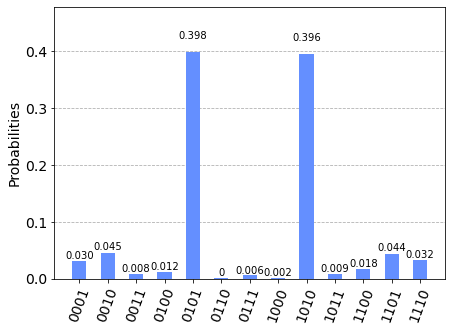

In [10]:
from qiskit.visualization import plot_histogram

qc_result = create_qaoa_circ(Ising_coeff, theta)
counts = backend.run(qc_result).result().get_counts()

plot_histogram(counts)

In [11]:
print(counts)

{'0110': 1, '0111': 6, '0010': 46, '0101': 408, '1010': 405, '1011': 9, '0011': 8, '0100': 12, '1110': 33, '1101': 45, '1100': 18, '0001': 31, '1000': 2}
